# Mixed Integer Linear Programming (MILP) Model for solving airport gate assignment problem

### Part 1 - Problem Description
### Part 2 - Assumptions
### Part 3 - Identify decision variable and set constraints
### Part 4 - Model formulation and result
### Part 5 - Visualization of gate assignment result using Gantt Chart

In [1]:
!pip install pulp
!pip install openpyxl
!pip install plotly --user

import pandas as pd
import numpy as np
from pulp import *

  Using cached PuLP-2.6.0-py3-none-any.whl (14.2 MB)
  Using cached openpyxl-3.0.10-py2.py3-none-any.whl (242 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [2]:
#import flight schedule data for arriving Mainland PAX flights in Nov-19)
turns = pd.read_excel("Nov_19_CN_Arr_Pax_flt.xlsx")

#Reformat date format (string->datetime)
turns['inbound_chocks_in'] = pd.to_datetime(turns['inbound_chocks_in']).dt.strftime('%Y-%m-%d %H:%M:%S')
turns['inbound_chocks_in'] = pd.to_datetime(turns['inbound_chocks_in'])

turns['outbound_chocks_out'] = pd.to_datetime(turns['outbound_chocks_out']).dt.strftime('%Y-%m-%d %H:%M:%S')
turns['outbound_chocks_out'] = pd.to_datetime(turns['outbound_chocks_out'])

In [3]:
#Assumption: The plane will be towed away from the original stand if it chocks over > 5 hrs
turns['max_occupied_to'] = turns['inbound_chocks_in'] + pd.Timedelta(hours=5)

#Towing plane indicator
turns['towing_required'] = turns['outbound_chocks_out'] > turns['max_occupied_to']

#Add <occupied to> to refer the last timestamp of the flight chocking in same stand
turns['occupied_to'] = turns[['outbound_chocks_out', 'max_occupied_to']].values.min(1)

In [4]:
#Assumption: The plane will be towed away from the original stand if it chocks over > 5 hrs
turns['max_occupied_to'] = turns['inbound_chocks_in'] + pd.Timedelta(hours=5)

#Towing plane indicator
turns['towing_required'] = turns['outbound_chocks_out'] > turns['max_occupied_to']

#Add <occupied to> to refer the last timestamp of the flight chocking in same stand
turns['occupied_to'] = turns[['outbound_chocks_out', 'max_occupied_to']].values.min(1)

#For towing plane, add additional one hour to cater for boarding, departing the plane and the physical process of towing
turns['occupied_to'] = np.where(turns['towing_required'], turns['occupied_to'] + pd.Timedelta(hours=1), turns['occupied_to'])

#Remove unused columns
turns = turns.drop(['max_occupied_to'], axis = 1)

In [5]:
#Add unique id for each flight record
turns.insert(0, 'turn_no', range(0, 0 + len(turns)))
turns

,turn_no,flight_id,arrival_departure_flag,inbound_chocks_in,outbound_chocks_out,aircraft_registration,original_destination_airport,airport_country,towing_required,occupied_to
0,0,CQH8959,A,2019-11-13 18:15:00,2019-11-13 19:29:00,B1025,PVG,China,False,2019-11-13 19:29:00
1,1,CQH8921,A,2019-11-20 12:11:00,2019-11-20 13:25:00,B1026,PVG,China,False,2019-11-20 13:25:00
2,2,CQH8921,A,2019-11-23 12:08:00,2019-11-23 13:27:00,B1026,PVG,China,False,2019-11-23 13:27:00
3,3,CQH8959,A,2019-11-04 18:03:00,2019-11-04 19:39:00,B1027,PVG,China,False,2019-11-04 19:39:00
4,4,CQH8959,A,2019-11-10 18:11:00,2019-11-10 19:42:00,B1027,PVG,China,False,2019-11-10 19:42:00
...,...,...,...,...,...,...,...,...,...,...
2850,2850,CRK241,A,2019-11-28 19:52:00,2019-11-28 20:48:00,BLPQ,PVG,China,False,2019-11-28 20:48:00
2851,2851,CRK497,A,2019-11-29 10:13:00,2019-11-29 11:09:00,BLPQ,CKG,China,False,2019-11-29 11:09:00
2852,2852,CRK170,A,2019-11-29 15:11:00,2019-11-29 19:07:00,BLPQ,SYX,China,False,2019-11-29 19:07:00
2853,2853,CRK158,A,2019-11-29 23:10:00,2019-11-30 01:56:00,BLPQ,HAK,China,False,2019-11-30 01:56:00


In [6]:
turns.to_excel("output.xlsx", index=False)

## Model C - Adding a Time Dimension

Gates can have more than one turn if they don't overlap

Think of this in discrete-time: 5 min buckets

Imagine we have these flights within the following intervals
```
00:00 - Flights 2, 5, 10
00:05 - Flights 2, 10, 11, 12
00:10 - Flights 11, 12
```
For each time-period we want to impose the gate-constraint

Only for turns in time-period; not ALL turns - something like:

```
for j in gates:
	x[2, j] + x[5, j] + x[10, j] <= 1
	x[2, j] + x[10, j] + x[11, j] + x[12, j] <= 1
	x[11, j] + x[12, j] <= 1
```

In [7]:
# Let's see how many planes we have at any one time
# We want to reshape our data to have an index of e.g 5 min intervals
# Columns are binary variables corresponding to whether the turn is at the airport

# Using discrete time-buckets
min_bucket=5

# Create time-series between arrival of first plane and departure of last
time_series = pd.Series(True, index= pd.date_range(
        start=turns.inbound_chocks_in.min(),
        end=turns.occupied_to.max(),
        freq=pd.offsets.Minute(min_bucket)))
    
# Truncate full time-series to [inbound_arrival, outbound_departure]
def trunc_ts(series):
    return time_series.truncate(series['inbound_chocks_in'], series['occupied_to'])
    
heatmapdf = turns.apply(trunc_ts, axis=1).T
    
# Convert columns from index to turn_no
heatmapdf.columns = turns['turn_no'].values

# Cast to integer
heatmapdf = heatmapdf.fillna(0).astype(int)
#heatmapdf.index = heatmapdf.index.time

heatmapdf.head()

,0,1,2,3,4,5,6,7,8,9,...,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854
2019-11-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-01 00:20:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-01 00:25:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-01 00:35:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model

In [8]:
turn_list = turns.turn_no.values
gate_list = np.array(['D201','D202','D203','D204','D205','D206',
                      'D207','D208','D209','D210','D211','D212',
                      'D213','D214','D215','D216','D217','D218', 'D219',
                      'D300','D301','D302','D303','D304','D305',
                      'D306','D307','D308','D309','D310','D311','D312',
                      'D313','D314','D315','D316','D317','D318', 'D319'])

In [9]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    for g in gate_list:
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

/opt/conda/lib/python3.7/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [10]:
# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1

# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket

In [11]:
# Set Preference: (1) Frontal Stand (D201-D219); (2) Remote Stand (D300-D319)
# Add all turns under those gates with a negative cost coefficient
neg_cost_coefficient = -5
prob += lpSum(neg_cost_coefficient*x[t, g] for t, g in x if g.startswith('D2'))

/opt/conda/lib/python3.7/site-packages/pulp/pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [12]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.7/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/71e7ddf2b30343ef9746ee9c5bf94621-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/71e7ddf2b30343ef9746ee9c5bf94621-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 289042 COLUMNS
At line 4561801 RHS
At line 4850839 BOUNDS
At line 4962185 ENDATA
Problem MODEL has 289037 rows, 111345 columns and 3995823 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -13895 - 9.89 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 53976 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 47596 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 40466 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 33822 strengthened rows, 0 substitutions
Cgl0003I 0 

In [13]:
## Save the solver result into a new column "assigned_stand" in df
results = {}

for alloc in x:
    if x[alloc].varValue:
        dicts = dict({alloc[0]: alloc[-1]})
        results.update(dicts)
    
turns['assigned_stand'] = turns['turn_no'].map(results)
turns.head()

,turn_no,flight_id,arrival_departure_flag,inbound_chocks_in,outbound_chocks_out,aircraft_registration,original_destination_airport,airport_country,towing_required,occupied_to,assigned_stand
0,0,CQH8959,A,2019-11-13 18:15:00,2019-11-13 19:29:00,B1025,PVG,China,False,2019-11-13 19:29:00,D214
1,1,CQH8921,A,2019-11-20 12:11:00,2019-11-20 13:25:00,B1026,PVG,China,False,2019-11-20 13:25:00,D211
2,2,CQH8921,A,2019-11-23 12:08:00,2019-11-23 13:27:00,B1026,PVG,China,False,2019-11-23 13:27:00,D214
3,3,CQH8959,A,2019-11-04 18:03:00,2019-11-04 19:39:00,B1027,PVG,China,False,2019-11-04 19:39:00,D207
4,4,CQH8959,A,2019-11-10 18:11:00,2019-11-10 19:42:00,B1027,PVG,China,False,2019-11-10 19:42:00,D218


### Gantt Chart Creation

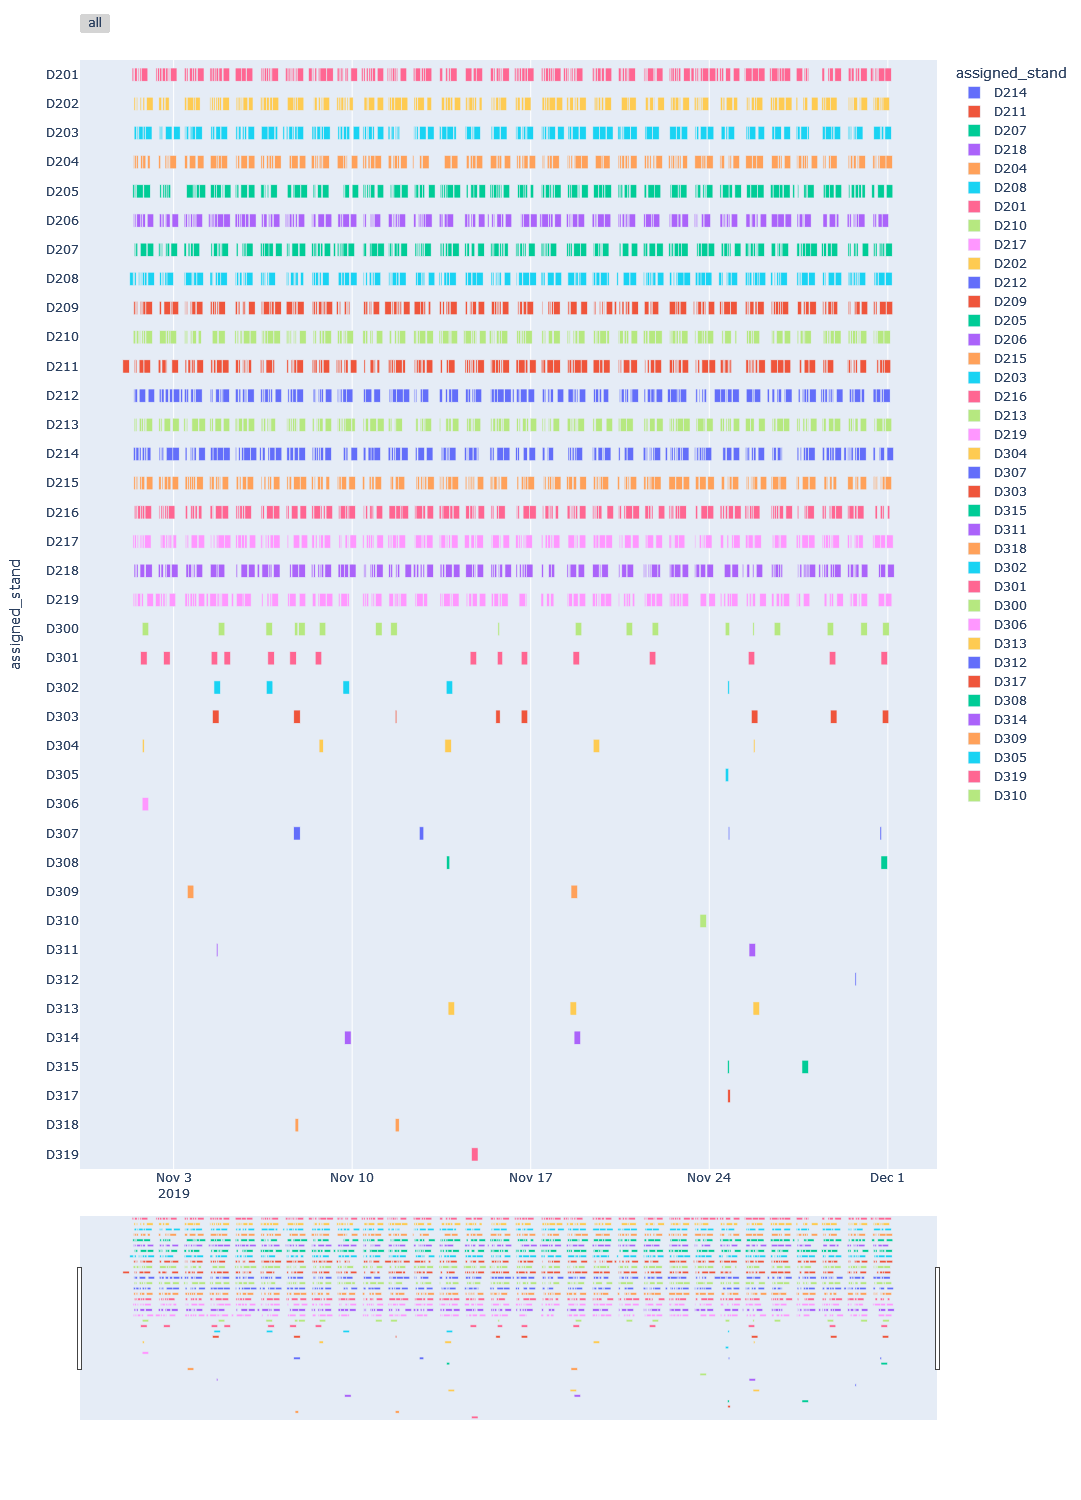

In [16]:
#import plotly open-source graphing libraries
import plotly.express as px

fig = px.timeline(turns, x_start="inbound_chocks_in", x_end="occupied_to", y="assigned_stand", color="assigned_stand",
                  hover_name='flight_id',
                  width=1200, height=1500)

#Set assigned stand order in y-axis
fig.update_yaxes(categoryorder = "category descending")

# Add range slider
fig.update_layout(bargap=0.5, bargroupgap=0.1,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)                  

fig.show()